In [1]:
import jax.numpy as jnp
from jax.scipy.linalg import expm
from scipy.stats import unitary_group
from jax import random
from matplotlib import pyplot as plt

from optimization import *

Introduce simple parameterization for generic unitary matrix through its hermitian logarithm.

In [2]:
def h3(h):
    return jnp.array([[h[0], h[1]+1j*h[2], h[3]+1j*h[4]],
                      [h[1]-1j*h[2], h[5], h[6]+1j*h[7]],
                      [h[3]-1j*h[4], h[6]-1j*h[7], h[8]]], dtype=jnp.complex64)
                    
def u3(h):
    return expm(1j*h3(h))

Let's check that a random unitary can be learned in this parametrization.

In [3]:
u_target = unitary_group.rvs(3, random_state=131)

res = unitary_learn(u3, u_target, 9, num_repeats=10)
success_hist = [r['loss'][-1] < 1e-5 for r in res]
print(sum(success_hist)/len(success_hist))

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

1.0


Introduce qutrit gates.

In [4]:
P0 = jnp.array([[1,0,0],
                [0,0,0],
                [0,0,0]], dtype=jnp.complex64)

P1 = jnp.array([[0,0,0],
                [0,1,0],
                [0,0,0]], dtype=jnp.complex64)

P2 = jnp.array([[0,0,0],
                [0,0,0],
                [0,0,1]], dtype=jnp.complex64)

Z01 = jnp.array([[1,0,0],
                 [0,-1,0],
                 [0,0,1]], dtype=jnp.complex64)

Id3 = jnp.array([[1,0,0],
                 [0,1,0],
                 [0,0,1]], dtype=jnp.complex64)

CZ = jnp.kron(P0+P2, Id3)+jnp.kron(P1, Z01)
  
def U3_CP(phi):
    return jnp.kron(P0+P2, Id3)+jnp.kron(P1, P0+P2)+jnp.exp(-1j*phi/2)*jnp.kron(P1, P1)

def U3_RZZ(phi):
    return jnp.exp(-1j*phi/2)*jnp.kron(P0, P0)+jnp.exp(1j*phi/2)*jnp.kron(P0, P1)+jnp.exp(1j*phi/2)*jnp.kron(P1, P0)+jnp.exp(-1j*phi/2)*jnp.kron(P1, P1)+jnp.kron(P2, P0+P1+P2)+jnp.kron(P0+P1, P2)

Ansatz with d layers of CNOTs.

In [27]:
def qutrit_anz(d):
    def u_anz(h):
        h = h.reshape(d+1, 2, 9)
        u = jnp.kron(u3(h[0,0]), u3(h[0, 1]))
        
        def apply_layer(i, u):
            u = CZ @ u
            u = jnp.kron(u3(h[i,0]), u3(h[i,1])) @ u
            return u
        
        if d > 0:
            u = lax.fori_loop(1, d+1, lambda i, u: apply_layer(i, u), u)

        
#         for k in range(1, d+1):
#             u = CZ @ u
#             u = jnp.kron(u3(h[k,0]), u3(h[k,1])) @ u
            
        return u
    
    return u_anz    

Let's check 3-CNOT ansatz can learn tensor product of random 2-qubit unitaries.

In [28]:
u0 = unitary_group.rvs(2, random_state=13)
u1 = unitary_group.rvs(2, random_state=14)

u0 = jnp.array([[u0[0,0], u0[0,1], 0],
                [u0[1,0], u0[1,1], 0],
                [0, 0, 1]])

u1 = jnp.array([[u1[0,0], u1[0,1], 0],
                [u1[1,0], u1[1,1], 0],
                [0, 0, 1]])

u01 = jnp.kron(u0, u1)
jnp.allclose(jnp.identity(9), u01 @ u01.conj().T, atol=1e-5)

DeviceArray(True, dtype=bool)

In [29]:
d=2
u_target = u01

loss_f = lambda h: (jnp.abs(qutrit_anz(d)(h)-u_target)**2).sum()

res = mynimize_repeated(loss_f, (d+1)*2*9, num_repeats=10)
success_hist = [r['loss'][-1] < 1e-5 for r in res]
print(sum(success_hist)/len(success_hist))

100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


0.4


Note that the problem of local minima is present already in this simple case!

Now let's try to learn the interesting gates.

In [42]:
d=2
phi = 0.01
# u_target = U3_CP(phi)
u_target = CZ

loss_f = lambda h: (jnp.abs(qutrit_anz(d)(h)-u_target)**2).sum()

res = mynimize_repeated(loss_f, (d+1)*2*9, num_repeats=10)
success_hist = [r['loss'][-1] < 1e-5 for r in res]
print(sum(success_hist)/len(success_hist))

100%|██████████| 10/10 [00:51<00:00,  5.10s/it]

0.1


In [43]:
success_hist

[DeviceArray(False, dtype=bool),
 DeviceArray(True, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool),
 DeviceArray(False, dtype=bool)]

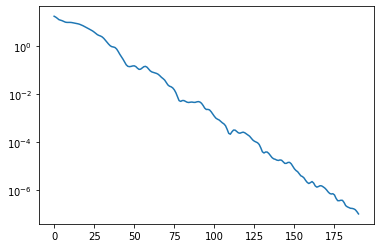

In [45]:
plt.plot(res[1]['loss'])
plt.yscale('log')